In [485]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
cwd = os.getcwd()
used_dataset_dir = os.path.join(cwd, 'Used_Dataset/cleaned_data')
train_data = pd.read_csv(os.path.join(used_dataset_dir, 'cleaned_data_2020_2022.csv'))
display(train_data.head())
display(train_data.tail())
display(train_data.isnull().sum())
display(train_data.shape)


,Date,Tn,Tx,Tavg,RH_avg,RR,ss,ff_x,ddd_x,ff_avg,rad(m)
0,2020-01-01,25.2,32.0,27.0,82.0,16.5,6.5,7.0,300.0,3.000000,-0.101338
1,2020-01-02,25.6,31.0,27.9,78.0,5.2,3.5,8.0,270.0,4.000000,-0.080959
2,2020-01-03,25.3,31.5,27.6,82.0,1.5,5.9,10.0,280.0,6.000000,-0.038172
3,2020-01-04,26.5,30.5,27.9,77.0,1.7,4.6,12.0,260.0,8.000000,-0.005176
4,2020-01-05,25.6,31.3,28.6,81.0,8.1,8.0,5.0,6.0,3.133748,-0.007169


,Date,Tn,Tx,Tavg,RH_avg,RR,ss,ff_x,ddd_x,ff_avg,rad(m)
726,2022-12-27,25.5,29.5,27.5,83.0,6.0,1.2,9.0,270.0,6.0,-0.024320
727,2022-12-28,24.5,29.1,26.9,84.0,2.3,0.0,9.0,270.0,5.0,-0.030015
728,2022-12-29,24.0,30.1,27.0,84.0,35.6,3.2,8.0,260.0,4.0,0.005127
729,2022-12-30,25.9,30.0,27.6,83.0,1.0,4.9,7.0,310.0,3.0,-0.009264
730,2022-12-31,24.9,32.2,27.7,83.0,0.0,0.6,7.0,280.0,3.0,-0.401817


Date      0
Tn        0
Tx        0
Tavg      0
RH_avg    0
RR        0
ss        0
ff_x      0
ddd_x     0
ff_avg    0
rad(m)    0
dtype: int64

(731, 11)

In [486]:
def advanced_condition_classifier(row):
    tn = row['Tn']  # Minimum Temperature
    tx = row['Tx']  # Maximum Temperature
    tavg = row['Tavg']  # Average Temperature
    rh = row['RH_avg']  # Average Relative Humidity
    wind_speed = row['ff_avg']  # Average Wind Speed
    tidal_height = row['rad(m)']  # Normalized tidal height (meters)

    # High Risk (Unsafe) Conditions
    if (tx > 38 and rh > 85) or (tavg > 34 and rh > 80 and wind_speed > 6) or \
       (tidal_height > 1.2 and tx > 36) or (wind_speed > 10) or (tidal_height > 1.5):
        return 'Tidak Aman'

    # Moderate Risk Conditions
    if (28 < tavg <= 34 and 70 < rh <= 85) or (27 < tavg <= 32 and wind_speed > 4) or \
       (0.5 < tidal_height <= 1.2 and rh > 70) or (tx - tn > 10) or (wind_speed > 5 and (tx > 33 or tn < 18)):
        return 'Risiko'

    # Safe Conditions
    if (22 <= tavg <= 27) and (60 <= rh <= 75) and (wind_speed < 4) and (tidal_height < 0.5):
        return 'Aman'

    return 'Risiko'

train_data['Condition'] = train_data.apply(advanced_condition_classifier, axis=1)

# Convert labels to numeric (Aman: 0, Risiko: 1, Tidak Aman: 2)
condition_mapping = {'Aman': 0, 'Risiko': 1, 'Tidak Aman': 2}
train_data['Condition'] = train_data['Condition'].map(condition_mapping)

# Check the results
print(train_data[['Date', 'Condition']].head())
condition_counts = train_data['Condition'].value_counts()

# Print counts per label
for label, count in condition_counts.items():
    condition_name = [key for key, value in condition_mapping.items() if value == label][0]
    print(f"{condition_name}: {count}")


         Date  Condition
0  2020-01-01          1
1  2020-01-02          1
2  2020-01-03          1
3  2020-01-04          1
4  2020-01-05          1
Risiko: 727
Aman: 4


In [487]:
# Select numeric features for normalization
numerical_features = ['Tn', 'Tx', 'Tavg', 'RH_avg', 'ff_avg', 'rad(m)']

# Normalize the data
scaler = MinMaxScaler()
train_data[numerical_features] = scaler.fit_transform(train_data[numerical_features])

# Check normalized data
print(train_data.head())


         Date        Tn        Tx      Tavg    RH_avg    RR   ss  ff_x  ddd_x  \
0  2020-01-01  0.481481  0.792208  0.500000  0.500000  16.5  6.5   7.0  300.0   
1  2020-01-02  0.530864  0.662338  0.660714  0.388889   5.2  3.5   8.0  270.0   
2  2020-01-03  0.493827  0.727273  0.607143  0.500000   1.5  5.9  10.0  280.0   
3  2020-01-04  0.641975  0.597403  0.660714  0.361111   1.7  4.6  12.0  260.0   
4  2020-01-05  0.530864  0.701299  0.785714  0.472222   8.1  8.0   5.0    6.0   

     ff_avg    rad(m)  Condition  
0  0.222222  0.392130          1  
1  0.333333  0.418725          1  
2  0.555556  0.474562          1  
3  0.777778  0.517623          1  
4  0.237083  0.515022          1  


In [488]:
# Remove rows with missing values
merged_data = train_data.dropna(subset=numerical_features + ['Condition'])

# Create sequences
sequence_length = 1
data_sequences = []

for i in range(len(merged_data) - sequence_length):
    sequence = merged_data[numerical_features].iloc[i:i + sequence_length].values
    data_sequences.append(sequence)

# Convert to numpy arrays
X = np.array(data_sequences)
y = merged_data['Condition'].iloc[sequence_length:].values

# Split data for training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=3)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.reshape(X_train.shape[0], -1), y_train)

# Reshape X_train back to original shape (sequence_length, num_features)
X_train_resampled = X_train_resampled.reshape(X_train_resampled.shape[0], sequence_length, X_train.shape[2])

# Check the class distribution after resampling
print(f"Class distribution after resampling:\n{pd.Series(y_train_resampled).value_counts(normalize=True)}")


Class distribution after resampling:
1    0.5
0    0.5
Name: proportion, dtype: float64


In [489]:
def create_lstm_model(sequence_length, num_features, num_classes):
    model = Sequential()
    model.add(LSTM(128, 
                   return_sequences=True,
                   input_shape=(sequence_length, num_features),
                   kernel_regularizer=L1L2(l1=1e-5, l2=1e-4)))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    
    model.add(LSTM(64, 
                   return_sequences=False,
                   kernel_regularizer=L1L2(l1=1e-5, l2=1e-4)))
    model.add(Dropout(0.3))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

# Create LSTM model
lstm_model = create_lstm_model(
    sequence_length=X_train_resampled.shape[1],  # Number of time steps
    num_features=X_train_resampled.shape[2],     # Number of features
    num_classes=3                                # Number of output classes
)

# Train the model
history = lstm_model.fit(
    X_train_resampled, y_train_resampled,
    epochs=30,
    batch_size=16,
    validation_data=(X_val, y_val),
    verbose=1,
    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5),
               EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)


Epoch 1/30


C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7252 - loss: 0.9280 - val_accuracy: 0.9932 - val_loss: 0.7551 - learning_rate: 0.0010
Epoch 2/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8981 - loss: 0.3843 - val_accuracy: 1.0000 - val_loss: 0.3157 - learning_rate: 0.0010
Epoch 3/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9331 - loss: 0.2648 - val_accuracy: 1.0000 - val_loss: 0.1644 - learning_rate: 0.0010
Epoch 4/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9362 - loss: 0.2213 - val_accuracy: 0.9932 - val_loss: 0.1264 - learning_rate: 0.0010
Epoch 5/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9208 - loss: 0.2363 - val_accuracy: 0.9932 - val_loss: 0.1091 - learning_rate: 0.0010
Epoch 6/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9433 - loss: 0.1968 - val_accuracy: 0.9726 - val_loss: 0.1173 - learning_rate: 0.0010
Epoch 7/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9114 - loss: 0.2732 - val_accuracy: 0.9589 - va

In [490]:
# Evaluate on training set (using resampled data)
train_loss, train_accuracy = lstm_model.evaluate(X_train_resampled, y_train_resampled)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Training Loss: {train_loss:.4f}")

# Make predictions on validation set
y_val_pred = lstm_model.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

# Check the unique classes in validation set and predictions
print(f"Unique classes in y_val: {np.unique(y_val)}")
print(f"Unique classes in y_val_pred_classes: {np.unique(y_val_pred_classes)}")

# Validation Accuracy
val_accuracy = accuracy_score(y_val, y_val_pred_classes)
print(f"\nValidation Accuracy: {val_accuracy * 100:.2f}%")

# Adjust target_names based on actual classes in y_val_pred_classes
num_classes = len(np.unique(y_val_pred_classes))
if num_classes == 3:
    target_names = ['Aman', 'Risiko', 'Tidak Aman']
elif num_classes == 2:
    target_names = ['Aman', 'Risiko']  # Adjust for 2 classes
else:
    target_names = ['Class 0', 'Class 1', 'Class 2']  # Fallback

print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_pred_classes, target_names=target_names))

# Confusion Matrix for Validation Set
cm_val = confusion_matrix(y_val, y_val_pred_classes)
print("\nValidation Confusion Matrix:")
print(cm_val)


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8126 - loss: 0.2775 
Training Accuracy: 49.57%
Training Loss: 0.5718
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Unique classes in y_val: [1]
Unique classes in y_val_pred_classes: [0 1]

Validation Accuracy: 99.32%

Validation Classification Report:
              precision    recall  f1-score   support

        Aman       0.00      0.00      0.00         0
      Risiko       1.00      0.99      1.00       146

    accuracy                           0.99       146
   macro avg       0.50      0.50      0.50       146
weighted avg       1.00      0.99      1.00       146


Validation Confusion Matrix:
[[  0   0]
 [  1 145]]


C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: U

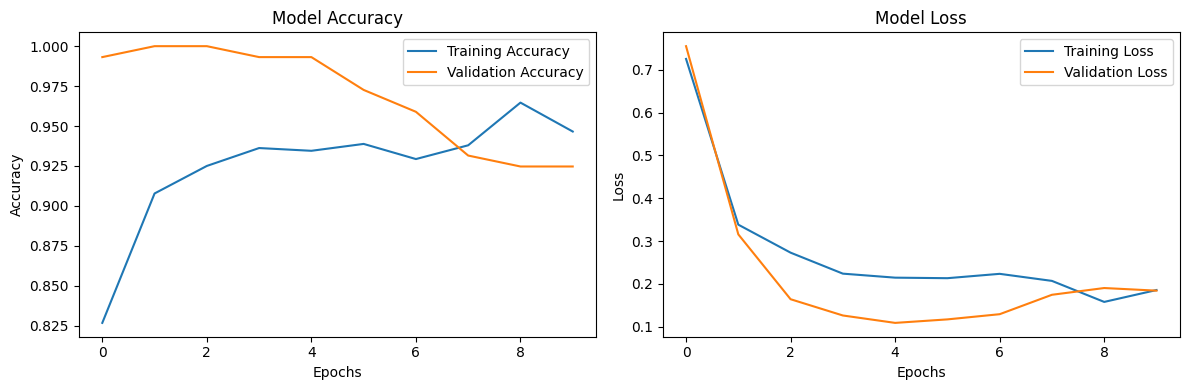

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


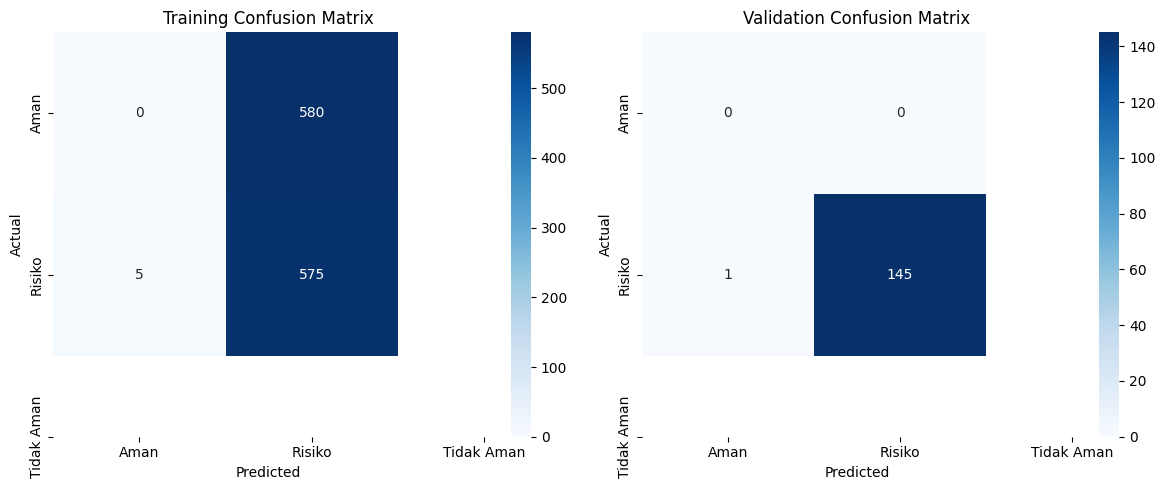

In [491]:

# Plot Accuracy and Loss
plt.figure(figsize=(12, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Confusion Matrix Visualization
plt.figure(figsize=(12, 5))

# Training Confusion Matrix
plt.subplot(1, 2, 1)
cm_train = confusion_matrix(y_train_resampled, np.argmax(lstm_model.predict(X_train_resampled), axis=1))
sns.heatmap(cm_train, annot=True, fmt='d', 
            xticklabels=['Aman', 'Risiko', 'Tidak Aman'],
            yticklabels=['Aman', 'Risiko', 'Tidak Aman'],
            cmap='Blues')
plt.title('Training Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Validation Confusion Matrix
plt.subplot(1, 2, 2)
cm_val = confusion_matrix(y_val, np.argmax(lstm_model.predict(X_val), axis=1))
sns.heatmap(cm_val, annot=True, fmt='d', 
            xticklabels=['Aman', 'Risiko', 'Tidak Aman'],
            yticklabels=['Aman', 'Risiko', 'Tidak Aman'],
            cmap='Blues')
plt.title('Validation Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()
